<h1> <center> Hyperspectral Imaging to classify Vegetative compatability groups (VCGs) of $Verticillium$ $dahliae$ </center></h1> 

**Objectives**

* Classify Vegetative compatibility groups (VCGs) of V. dahliae using hyperspectral imagery
* Evaluate performance of different machine learning models to classify VCGs based on spectral reflectance and texture features

**HSI Analysis Work flow**

* Acquire data
    * Dark reference
    * White reference
    * Data
    * Acquired images for each isolate are in the separate folder. There are total 228 folders. Each folder has dark, white and data image which will be used for the calibration of image.
* Image pre-processing
    * Image calibration
        * calibrated image = $ Rawimage(I)- darkimage(I)/ whiteimage(I)-darkimage(I)$
    * Circular mask creation and Image segementation
    * Calculate mean spectra
    * Normalization
    * Cut first and last four bands for enhanced signal to noise ratio
* Feature Extraction and Selection
    * Feature Extraction/Ordination (PCA, LDA)
    * Feature Selection (LASSO, Random Forest, SVM(linear))
* Inference
    * SVM
    * KNN 
    * Random forest
    * CNN
* Identification and interpretation
* Reference 
    * [Paulus and Mahleing 2020](https://academic.oup.com/gigascience/article/9/8/giaa090/5894826)
    * [Xie et al 2015](https://www.nature.com/articles/srep16564)

## Import data

**Import Python Packages**

In [1]:
#Packages 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline
import seaborn as sns # plotting
import pandas as pd
import os
import pathlib

In [41]:
df = pd.read_csv('./Data/2021/Combined/df_features_all.csv')
print(df.shape)
df.head()

(746, 623)


,Isolate,Replication,VCG,574.932_all,583.221_all,591.509_all,599.798_all,608.086_all,616.374_all,624.663_all,...,perimeter_all,solidity_all,compactness_all,area_gray,eccentricity_gray,major_axis_length_gray,minor_axis_length_gray,perimeter_gray,solidity_gray,compactness_gray
0,100,1,2B,0.228179,0.241779,0.251570,0.260101,0.268141,0.275407,0.281489,...,1463.218434,0.633821,4.661245,5384,0.353545,216.328109,202.357133,1254.176803,0.263857,1.545551
1,100,3,2B,0.202215,0.200691,0.201909,0.205145,0.207361,0.213640,0.218978,...,1366.810317,0.588505,4.163811,4915,0.253699,221.334321,214.092966,1067.259018,0.228276,1.303414
2,10,1,4A,0.527239,0.549440,0.568393,0.583382,0.596930,0.611416,0.623855,...,552.558441,0.994402,9.846371,2741,0.529670,120.981989,102.617397,861.086399,0.354317,2.774452
3,10,2,4A,0.534530,0.554637,0.572590,0.587962,0.602182,0.617135,0.630760,...,422.818326,0.992377,9.869066,673,0.865648,116.893786,58.523303,298.273124,0.161974,1.236245
4,10,3,4A,0.151773,0.173584,0.182473,0.198057,0.210361,0.220400,0.229987,...,551.830519,0.240701,1.819535,713,0.811296,124.449119,72.757359,362.326948,0.118164,0.989534


In [42]:
df = df[(df['VCG'] == '2B') | (df['VCG'] == '4A') | (df['VCG'] == '4B')]
print(df.shape)

(715, 623)


In [43]:
# Replace '4A' with '4B' in the 'VCG' column
# Map '4A' to '4B' and keep other values unchanged
df['VCG'] = df['VCG'].map({'2B': '4B'}).fillna(df['VCG'])
df.shape

(715, 623)

In [44]:
df = df.fillna(0)

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [46]:
# Perform stratified split by VCG
df_train = pd.DataFrame()
df_test = pd.DataFrame()

# Iterate through each VCG to split isolates within each class
for vcg, group in df.groupby("VCG"):
    # Get unique isolates for the current VCG
    unique_isolates = group["Isolate"].unique()
    
    # Split isolates into train and test sets (70% train, 30% test)
    train_isolates, test_isolates = train_test_split(unique_isolates, test_size=0.3, random_state=99163)
    
    # Subset data for train and test based on isolates
    train_subset = group[group["Isolate"].isin(train_isolates)]
    test_subset = group[group["Isolate"].isin(test_isolates)]
    
    # Append to overall train and test datasets
    df_train = pd.concat([df_train, train_subset])
    df_test = pd.concat([df_test, test_subset])

print(df_train.shape)
print(df_test.shape)


(502, 623)
(213, 623)


### Train set

In [47]:
train_features_name = df_train[['Isolate','VCG']]
print(train_features_name.shape)
train_ref_all = df_train.iloc[:, 3:539]
print(train_ref_all.shape)
train_ref_whole = train_ref_all.loc[:, train_ref_all.columns.str.endswith('_all')]
print(train_ref_whole.shape)

#7 textural features from 10 wavelengths
train_tex_all = df_train.iloc[:, 539:609]
print(train_tex_all.shape)
train_tex_1205 = train_tex_all.filter(regex='_1205$')
print(train_tex_1205.shape)

#7 morpho features from 2 tyeps 
train_morph_all = df_train.iloc[:,609:]
print(train_morph_all.shape)
train_morph_whole = train_morph_all.loc[:, train_morph_all.columns.str.endswith('_all')]
print(train_morph_whole.shape)

train_combined = pd.DataFrame(pd.concat([train_ref_whole, train_tex_all, train_morph_whole],axis =1))
train_combined.shape

(502, 2)
(502, 536)
(502, 134)
(502, 70)
(502, 7)
(502, 14)
(502, 7)


(502, 211)

### Test set

In [48]:
test_features_name = df_test[['Isolate','VCG']]
print(test_features_name.shape)
test_ref_all = df_test.iloc[:, 3:539]
print(test_ref_all.shape)
test_ref_whole = test_ref_all.loc[:, test_ref_all.columns.str.endswith('_all')]
print(test_ref_whole.shape)

#7 textural features from 10 wavelengths
test_tex_all = df_test.iloc[:, 539:609]
print(test_tex_all.shape)
test_tex_1205 = test_tex_all.filter(regex='_1205$')
print(test_tex_1205.shape)

#7 morpho features from 2 tyeps 
test_morph_all = df_test.iloc[:,609:]
print(test_morph_all.shape)
test_morph_whole = test_morph_all.loc[:, test_morph_all.columns.str.endswith('_all')]
print(test_morph_whole.shape)

test_combined = pd.DataFrame(pd.concat([test_ref_whole, test_tex_all, test_morph_whole],axis =1))
test_combined.shape

(213, 2)
(213, 536)
(213, 134)
(213, 70)
(213, 7)
(213, 14)
(213, 7)


(213, 211)

### Features for training

In [49]:
X_train = np.array(pd.concat([train_combined],axis =1))
print(X_train.shape)

X_train = np.array(StandardScaler().fit_transform(X_train))
y_train = pd.Categorical(pd.factorize(train_features_name.VCG)[0])
print(y_train.shape)
print(y_train)

(502, 211)
(502,)
[0, 0, 0, 0, 0, ..., 1, 1, 1, 1, 1]
Length: 502
Categories (2, int64): [0, 1]


In [50]:
X_test = np.array(pd.concat([test_combined],axis =1))
print(X_test.shape)

X_test = np.array(StandardScaler().fit_transform(X_test))
y_test = pd.Categorical(pd.factorize(test_features_name.VCG)[0])
print(y_test.shape)
print(y_test)

(213, 211)
(213,)
[0, 0, 0, 0, 0, ..., 1, 1, 1, 1, 1]
Length: 213
Categories (2, int64): [0, 1]


### RF, SVM, LDA, KNN and DT

In [30]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

**KNN**
* Assumption
    * Data points that are similar have similar label
* Non-parametric method so no assumptions are made about the decision boundry for the particular data
* Performs better when the decision boundaries are non-linear
* Unlike other methods it memorizes the training data and find k number of training examples closest to the test point(x)(sample to be predicted) and classify the observation to class with the highest probablity 
* Generally, Minkowski distance is frequently used for the distance function
* Low k: High variance and low bias; High k: High bias and low variance
* Pick odd number for k for ease in majority voting
* Can't be used for inference (to know the important predictors and and relationship between predictors and target)
* KNN doesn't work well on high dimensional data

**References**
* [James et al. An Introduction to Statistical Learning](https://static1.squarespace.com/static/5ff2adbe3fe4fe33db902812/t/601cc86d7f828c4792e0bcae/1612499080032/ISLR+Seventh+Printing.pdf)
* [KNN Algorithm for Machine Learning](https://medium.com/capital-one-tech/k-nearest-neighbors-knn-algorithm-for-machine-learning-e883219c8f26)
* [KNN- Cornell lecture](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote02_kNN.html)

**KNN Hyperparameter Tuning**

In [54]:
model_knn = KNeighborsClassifier()
parameters = [{'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}]
grid_search = GridSearchCV(estimator = model_knn,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 4,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 71.64 %
Best Parameters: {'n_neighbors': 4}


**SVM Hyperparameter Tuning**

In [55]:
model_svm = SVC(random_state = 123)#SVC is for one vs rest comparision in multiclass classification
parameters = [{'C': [0.01, 0.1, 1, 10],
              'gamma':[1, 0.1, 0.01],
              'kernel': ('poly', 'linear','rbf')}]
grid_search = GridSearchCV(estimator = model_svm,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 4,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 73.66 %
Best Parameters: {'C': 10000, 'gamma': 0.001, 'kernel': 'rbf'}


**RF Hyperparameter Tuning**

In [56]:
model_rf = RandomForestClassifier(random_state = 55)
parameters = [{'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 500, num = 20)],
              'max_depth':[None,1,2,3,4,5],
              }]
grid_search = GridSearchCV(estimator = model_rf,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 4,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 71.05 %
Best Parameters: {'max_depth': None, 'n_estimators': 50}


### All ML models

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Example X and y (replace with your own data)
# Assume X_train, X_test, y_train, y_test are already defined
# Example: X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Define your models
models = [('LDA', LDA(n_components=2)),
          ('RF', RandomForestClassifier(n_estimators=150, class_weight='balanced', random_state=123)),
          ('KNN', KNeighborsClassifier(n_neighbors=10)),
          ('SVM', SVC(C=10, gamma=1, kernel='rbf', random_state=55, class_weight='balanced')),
          ]

# Store results for all models
results_overall = []
results_class = []
model_names = []

# Iterate through each model
for name, model in models:
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    acc_overall = accuracy_score(y_test, y_pred)  # Overall accuracy
    cfx = confusion_matrix(y_test, y_pred, normalize='true')  # Confusion matrix
    acc_class = np.diagonal(cfx)  # Class-specific accuracy
    score_class = precision_recall_fscore_support(y_test, y_pred)  # Class-specific metrics
    score_overall = precision_recall_fscore_support(y_test, y_pred, average='macro')  # Overall metrics
    
    # Combine results for overall metrics
    combined_scores_overall = [acc_overall] + list(score_overall[:3])  # Accuracy, Precision, Recall, F1
    results_overall.append(combined_scores_overall)  # Store overall results for the model
    
    # Combine results for class-specific metrics
    combined_scores_class = np.concatenate((np.reshape(acc_class, (1, len(acc_class))), np.array(score_class[:3])))
    results_class.append(combined_scores_class)  # Store class-specific results for the model
    
    # Store model name
    model_names.append(name)

# Convert results to numpy arrays
results_overall = np.array(results_overall)
results_class = np.array(results_class)

# Print the shapes of the results
print("Overall Results Shape:", results_overall.shape)  # Shape: (number of models, 4) ['accuracy', 'precision', 'recall', 'f1']
print("Class-Specific Results Shape:", results_class.shape)  # Shape: (number of models, number of metrics, number of classes)

# Display the overall results for each model
df_overall = pd.DataFrame(results_overall, columns=['Accuracy', 'Precision', 'Recall', 'F1_score'], index=model_names)
print("Overall Results for Each Model:")
print(df_overall)


**Classification report overall**

In [32]:
col_name = ['Accuracy', 'Precision', 'Recall','F1_score']#sequence of the metrics in the array[colnames]
df_report_overall = pd.DataFrame(results_overall, columns=list(col_name))
df_report_overall['Model']= model_names#add column for model information
df_report_overall['Dataset'] = ['12days_all']*len(df_report_overall)
print(df_report_overall)

Empty DataFrame
Columns: [Accuracy, Precision, Recall, F1_score, Model, Dataset]
Index: []


In [ ]:
melt_report_overall = df_report_overall.melt(id_vars = ['Model','Dataset'], value_name = 'Score')#define id_vars and melt data
print('before: %s, after: %s'%(df_report_overall.shape, melt_report_overall.shape))#show shape of the file before and after meltingd
melt_report_overall = melt_report_overall.rename({'variable':'Parameter'}, axis=1)#rename the column 'variable'
melt_report_overall.head()

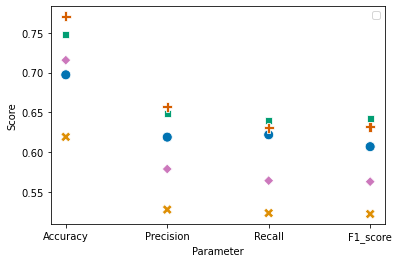

In [100]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.scatterplot(x="Parameter", y="Score", hue = 'Model', style = 'Model',data=melt_report_overall, s = 100, palette = 'colorblind')
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
ax.set_title('')
#ax.set(xticklabels = [])#remove the ticks label
#ax.set(xlabel=None)#remove axis label
plt.legend([],[], frameon=True)
#plt.savefig('Figures/clf_report_12days_scaled/clf_overall_entire_12days_N+S.png', dpi = 300)
plt.show()

In [ ]:
metrics = ['Accuracy', 'Precision','Recall','F1_score']#list of the metrics in sequence
column = ['vcg_2B','vcg_4A','vcg_4B']
df = pd.DataFrame(results_class.reshape(-1, 3), columns=list(column))#change dataframe
df.insert(0, 'Parameter', metrics*results_class.shape[0])#insert metrics as a first column 
df['Model'] = np.repeat(model_names, repeats = results_class.shape[1])# Insert model column with the name of models 
df['Dataset'] = ['ref']*len(df)#Insert the dataset column 
df_report_class = df
print(df_report_class.head(20))

In [ ]:
melt_report_class = df_report_class.melt(id_vars = ['Parameter','Model','Dataset'], value_name = 'Score')#define id_vars and melt data
print('before: %s, after: %s'%(df_report_class.shape, melt_report_class.shape))#show shape of the file before and after melting
melt_report_class = melt_report_class[melt_report_class['Parameter']!='Support']#Remove support from metrics column
melt_report_class = melt_report_class.rename({'variable':'VCG'}, axis=1)#rename the column 'variable'
print(melt_report_class.head())

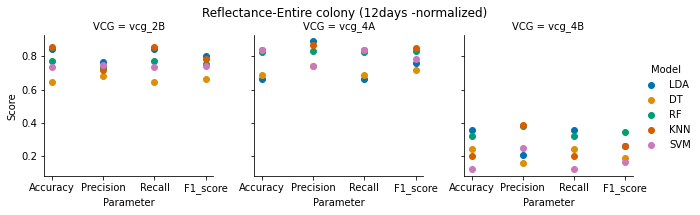

In [52]:
ax = sns.FacetGrid(data = melt_report_class , col = 'VCG', hue = 'Model', palette = 'colorblind')
ax.map(plt.scatter, 'Parameter','Score', alpha =1)
ax.add_legend()
ax.fig.subplots_adjust(top=0.85)
ax.fig.suptitle('Reflectance-Entire colony (12days -normalized)')
#plt.savefig('Figures/clf_class_Entire_12days_N+S.png', dpi = 300)
plt.show()

### Single Model

In [51]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=150, random_state=123, class_weight='balanced')

# Fit the model on the training set
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate overall metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')

# Print performance metrics
print(f'Overall Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

Overall Accuracy: 0.87
Precision: 0.87
Recall: 0.87
F1-Score: 0.87


In [ ]:
# Assuming `avg_confusion_matrix` is your confusion matrix data
fig, ax = plt.subplots(figsize=(3, 3))

# Create the heatmap
heatmap = sns.heatmap(conf_matrix, cmap='Reds', annot=True, ax=ax,
                      xticklabels=['2B', '4A', '4B'],  # Update the order of x-tick labels
                      yticklabels=['2B', '4A', '4B'], fmt='.2f', cbar=False,
                      annot_kws={"fontsize": 12})  # Set default annotation font size
# Set axis labels
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)

# Make diagonal values bold and increase their font size
for text in heatmap.texts:
    if text.get_position()[0] == text.get_position()[1]:  # Check if it is a diagonal value
        text.set_fontsize(12)  # Increase diagonal font size
        text.set_fontweight('bold')  # Make diagonal font bold

# Adjust layout
plt.tight_layout()
# Save the plot if needed
#plt.savefig('confusion_matrix_2Bvsall.jpg', dpi=300)
# Display the plot
plt.show()

### Artificial Neural Network

In [53]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers, optimizers, metrics, losses
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

**Change targets into dummy variables**

In [54]:
n_classes =2
y_train_ann = keras.utils.to_categorical(y_train, num_classes = n_classes)
print(y_train.shape)
y_test_ann = keras.utils.to_categorical(y_test, num_classes = n_classes)
y_test.shape

(502,)


(213,)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

# Variables to store results
train_acc = []
train_loss = []
acc_test = []
score_test = []
cfx_test = []

# Build the neural network model
model = Sequential()
model.add(Dense(90, input_dim=X_train.shape[1], activation='relu'))  # Input layer with 90 neurons

# Additional hidden layers
#model.add(Dense(64, activation='relu'))  # First additional hidden layer with 64 neurons
#model.add(Dense(32, activation='relu'))  # Second additional hidden layer with 32 neurons
#model.add(Dense(16, activation='relu'))  # Third additional hidden layer with 16 neurons


model.add(Dense(2, activation='softmax'))  # Output layer with 3 classes
model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_ann, batch_size=3, epochs=200, verbose=0)

# Training metrics
train_acc = history.history['accuracy']
train_loss = history.history['loss']

# Evaluate on the test set
y_pred = np.argmax(model.predict(X_test), axis=1)
y_test_actual = np.argmax(y_test_ann, axis=1)

# Calculate test metrics
acc_test.append(accuracy_score(y_test_actual, y_pred))
cfx_test.append(confusion_matrix(y_test_actual, y_pred, labels=[0, 1, 2], normalize='true'))
score_test.append(precision_recall_fscore_support(y_test_actual, y_pred, labels=[0, 1, 2], average='macro'))

# Calculate average metrics
avg_test_acc = np.mean(acc_test)
avg_precision, avg_recall, avg_f1 = score_test[0][:3]

# Print results
print('Test Accuracy: %.3f' % avg_test_acc)
print('Test Precision: %.3f' % avg_precision)
print('Test Recall: %.3f' % avg_recall)
print('Test F1 Score: %.3f' % avg_f1)
print('Training Accuracy: %.3f' % (np.mean(train_acc) * 100))
print('Training Loss: %.3f' % np.mean(train_loss))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
cfx_test = np.mean(cfx_test, axis=0)
# Assuming c_matrix is your confusion matrix data
fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.heatmap(cfx_test, cmap='Greys', annot=True, ax=ax,
                 xticklabels=['VCG_2B', 'VCG_4A', 'VCG_4B'],  # Update the order of x-tick labels
                 yticklabels=['VCG_2B', 'VCG_4A', 'VCG_4B'])  # Update the order of y-tick labels

ax.set_xlabel('Predicted Label', fontsize=10)
ax.set_ylabel('True Label', fontsize=10)

plt.tight_layout()
# Save the plot if needed
#plt.savefig('ann_all_features_final_train_test.png', dpi=300)
plt.show()

### Feature Selection

Why feature selection?
* Remove uniformatic features
* Reduces overfitting
* Improves model performance
* Reduces computational cost

---

#### Least Absolute Shrinkage and Selection Operator (LASSO)

**LASSO**
* Parametric method, 
* Supervised learning method based on linear regression with l1 regularization
* LASSO penalizes the linear regression model by shrinking the coefficient to near to zero or exactly zero and helps to reduce the model complexity and deals with multicollinearity. 
* Prevents from overfitting and also be used for feature selection
* Produces highly interpretable models

**Reference** 
* [James et al. An Introduction to Statistical Learning](https://static1.squarespace.com/static/5ff2adbe3fe4fe33db902812/t/601cc86d7f828c4792e0bcae/1612499080032/ISLR+Seventh+Printing.pdf)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE#recursive feature elimination

**Hyperparameter tuning for Lasso**

* Hyperparameter tuing for the C value. According to scikit, C = 1/lamda, 
High C = high variance, 
low C = high bias, 
C = 0 equals to linear regression

In [31]:
model_lasso = LogisticRegression(penalty="l1", max_iter =1000)
parameters = [{'C': [0.1,0.5,1, 10],
              'solver':('liblinear', 'saga')}]
grid_search = GridSearchCV(estimator = model_lasso,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 4,
                           n_jobs = -1)
grid_search = grid_search.fit(X,y)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 73.70 %
Best Parameters: {'C': 10, 'solver': 'liblinear'}


In [18]:
import pandas as pd

# Modify column names by extracting the numeric part and rounding, ignoring non-numeric columns
df_wavelength = pd.DataFrame([
    str(round(float(col.split('_')[0]))) if col.split('_')[0].replace('.', '', 1).isdigit() else col
    for col in train_ref_whole.columns])

# Create a new column called 'Wavelength' from the processed column names
df_wavelength.columns = ['Wavelength']  # Rename the single column
df_wavelength['Wavelength'] = df_wavelength['Wavelength']  # Assign to 'Wavelength'

# Display the shape of the DataFrame
print("DataFrame Shape:", df_wavelength.shape)

# Display the first few rows to verify
df_wavelength.head()


DataFrame Shape: (134, 1)


,Wavelength
0,575
1,583
2,592
3,600
4,608


**Feature Selection using SelectFromModel**

In [19]:
model_lasso = SelectFromModel(LogisticRegression(C =0.25, penalty="l1", max_iter =1000,solver='liblinear'
                            ,random_state = 55),max_features=15)
model_lasso.fit(X_train, y_train)
Ranked_lasso = pd.DataFrame(model_lasso.get_support())
Ranked_lasso['Wavelength'] = df_wavelength['Wavelength'].values#Add wavelength information to the Ranked dataframe
Ranked_lasso.columns = ['Rank', 'Wavelength']#Rename the columns
Ranked_lasso['Rank'] = Ranked_lasso['Rank']*1 # Change boolean to 0 and 1. If true 1, else 0
Imp_features_LR = Ranked_lasso[Ranked_lasso['Rank'] == 1]#Select top ten features
# Assuming model_lasso is the trained SelectFromModel with LogisticRegression

coef_matrix = model_lasso.estimator_.coef_  # Extract the coefficient matrix
zero_coef_features = np.sum(np.abs(coef_matrix), axis=0) == 0
features_shrunk_to_zero = np.sum(zero_coef_features)
print(f"Number of features shrunk to zero: {features_shrunk_to_zero}")
Imp_features_LR

Number of features shrunk to zero: 117


,Rank,Wavelength
0,1,575
30,1,824
57,1,1047
58,1,1056
84,1,1271
85,1,1279
86,1,1288
87,1,1296
88,1,1304
89,1,1313


**Feature Selection using Recursive Feature Elimination**

In [72]:
model_lasso = LogisticRegression(C =0.2, penalty="l1", max_iter =1000,solver='liblinear', random_state = 42)
rfe_lasso = RFE(model_lasso, n_features_to_select=13, step=1)#fit rfe and select top 10 features
fit_lasso = rfe_lasso.fit(X_train, y_train)# fit the model in dataset
Ranked_lasso = pd.DataFrame(fit_lasso.ranking_)
Ranked_lasso['Wavelength'] = df_wavelength['Wavelength'].values#Add wavelength information to the Ranked dataframe
Ranked_lasso.columns = ['Rank', 'Wavelength']#Rename the columns
Imp_features_lasso = Ranked_lasso[Ranked_lasso['Rank'] == 1]#Select top ten features
Imp_features_lasso

,Rank,Wavelength
0,1,575
7,1,633
86,1,1288
92,1,1337
93,1,1346
94,1,1354
95,1,1362
96,1,1371
97,1,1379
98,1,1387


In [ ]:
# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=150, random_state=55)
rf_model.fit(X_train, y_train)

# Calculate Gini importance
feature_importances = rf_model.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': ref_subset.columns,
    'Gini Importance': feature_importances
}).sort_values(by='Gini Importance', ascending=False)

# Select only the top 15 features
top_features_df = feature_importance_df.head(15)

# Display the top 15 feature importances
print("Top 15 Gini Feature Importances:\n", top_features_df)

# Plotting the top 15 Gini importances
plt.figure(figsize=(10, 8))
plt.barh(top_features_df['Feature'], top_features_df['Gini Importance'], color='skyblue')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importance Based on Gini Index')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
plt.show()

### **Machine learning on Selected Features**

In [139]:
# Extract the row indices from `Imp_features_LR`
selected_rows = Imp_features_LR.index.tolist()  # Convert the indices to a list

In [ ]:
train_ref_subset = train_ref_whole.iloc[:, selected_rows]
train_ref_subset.head()

X1_train = np.array(pd.concat([train_ref_subset],axis =1))
print(X1_train.shape)

X1_train = np.array(StandardScaler().fit_transform(X1_train))
print(X1_train.shape)
y1_train = pd.Categorical(pd.factorize(train_features_name.VCG)[0])
print(y1_train.shape)
print(y1_train)

In [ ]:
test_ref_subset = test_ref_whole.iloc[:, selected_rows]
test_ref_subset.head()

X1_test = np.array(pd.concat([test_ref_subset],axis =1))
print(X1_test.shape)

X1_test = np.array(StandardScaler().fit_transform(X1_test))
print(X1_test.shape)
y1_test = pd.Categorical(pd.factorize(test_features_name.VCG)[0])
print(y1_test.shape)
print(y1_test)

#### All ML models

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Example X and y (replace with your own data)
# Assume X_train, X_test, y_train, y_test are already defined
# Example: X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Define your models
models = [('LDA', LDA(n_components=2)),
          ('DT', DecisionTreeClassifier(random_state=55)),
          ('RF', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=123)),
          ('KNN', KNeighborsClassifier(n_neighbors=10)),
          ('SVM', SVC(C=10, gamma=1, kernel='rbf', random_state=55, class_weight='balanced')),
          ]

# Store results for all models
results_overall = []
results_class = []
model_names = []

# Iterate through each model
for name, model in models:
    # Fit the model on the training data
    model.fit(X1_train, y1_train)
    
    # Predict on the test data
    y1_pred = model.predict(X1_test)
    
    # Calculate metrics
    acc_overall = accuracy_score(y1_test, y1_pred)  # Overall accuracy
    cfx = confusion_matrix(y1_test, y1_pred, normalize='true')  # Confusion matrix
    acc_class = np.diagonal(cfx)  # Class-specific accuracy
    score_class = precision_recall_fscore_support(y1_test, y1_pred)  # Class-specific metrics
    score_overall = precision_recall_fscore_support(y1_test, y1_pred, average='macro')  # Overall metrics
    
    # Combine results for overall metrics
    combined_scores_overall = [acc_overall] + list(score_overall[:3])  # Accuracy, Precision, Recall, F1
    results_overall.append(combined_scores_overall)  # Store overall results for the model
    
    # Combine results for class-specific metrics
    combined_scores_class = np.concatenate((np.reshape(acc_class, (1, len(acc_class))), np.array(score_class[:3])))
    results_class.append(combined_scores_class)  # Store class-specific results for the model
    
    # Store model name
    model_names.append(name)

# Convert results to numpy arrays
results_overall = np.array(results_overall)
results_class = np.array(results_class)

# Print the shapes of the results
print("Overall Results Shape:", results_overall.shape)  # Shape: (number of models, 4) ['accuracy', 'precision', 'recall', 'f1']
print("Class-Specific Results Shape:", results_class.shape)  # Shape: (number of models, number of metrics, number of classes)

# Display the overall results for each model
df_overall = pd.DataFrame(results_overall, columns=['Accuracy', 'Precision', 'Recall', 'F1_score'], index=model_names)
print("Overall Results for Each Model:")
print(df_overall)


In [ ]:
metrics = ['Accuracy', 'Precision','Recall','F1_score']#list of the metrics in sequence
column = ['vcg_2B','vcg_4A','vcg_4B']
df = pd.DataFrame(results_class.reshape(-1, 3), columns=list(column))#change dataframe
df.insert(0, 'Parameter', metrics*results_class.shape[0])#insert metrics as a first column 
df['Model'] = np.repeat(model_names, repeats = results_class.shape[1])# Insert model column with the name of models 
df['Dataset'] = ['ref']*len(df)#Insert the dataset column 
df_report_class = df
print(df_report_class.head(20))

---

---

---